In [4]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from AEDataset import AEDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN
from AE import AE
from sklearn.metrics import r2_score
import similarities

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
l1000 = torch.load('../../LINCS_DVRL/data/proc/l1000.pt')
sample_ids = open('../../LINCS_DVRL/data/proc/l1000_row_sample_ids.txt').read().split(',')
l1000.size()

torch.Size([945263, 978])

In [6]:
apc = pd.read_csv('../../LINCS_DVRL/data/APC/lvl4_APC.csv')
apc = apc.fillna(-666)
apc = pd.DataFrame({'sample_id':sample_ids}).merge(apc, on='sample_id', how='left') # order identically to l1000 
apc = apc.assign(train=lambda x: x.APC < 0.7)
apc = apc.assign(valid=lambda x: x.APC >= 0.7)
apc.head()

,sample_id,APC,nrepl,L1,L2,train,valid
0,ABY001_A375_XH_X1_B15:A13,0.324414,8.0,1.649418,11.675443,True,False
1,ABY001_A375_XH_X1_B15:A14,0.189060,10.0,1.265392,4.093121,True,False
2,ABY001_A375_XH_X1_B15:A15,0.436836,9.0,2.257690,11.702172,True,False
3,ABY001_A375_XH_X1_B15:A16,0.089820,8.0,0.961196,2.485945,True,False
4,ABY001_A375_XH_X1_B15:A17,0.367309,8.0,1.855790,9.666554,True,False


In [7]:
train_idx = (apc.train.values * 1.).nonzero()[0]
valid_idx = (apc.valid.values * 1.).nonzero()[0]

In [8]:
x_train = l1000[train_idx, :]
x_valid = l1000[valid_idx, :]

In [9]:
train_dataset = AEDataset(x_train)
valid_dataset = AEDataset(x_valid)

/home/teddy/local/DVGS/manuscript_notebooks/../src/AEDataset.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [10]:
len(train_dataset)

926659

In [11]:
len(valid_dataset)

18604

In [12]:
model = AE(in_channels=978, latent_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, num_layers=1)
dvgs = DVGS(train_dataset, valid_dataset, test_dataset=None, model=model)
dvgs.pretrain_(crit=torch.nn.MSELoss(), num_workers=5, batch_size=512, lr=1e-3, epochs=1, use_cuda=True, verbose=True, report_metric=lambda x,y: r2_score(x,y, multioutput='uniform_average'))

using device: cuda


In [13]:
_ = [print(f'"{n}",',end='') for n,p in model.named_parameters()]

"encoder.f.0.weight","encoder.f.0.bias","encoder.f.4.weight","encoder.f.4.bias","encoder.f.5.weight","encoder.f.5.bias","decoder.f.0.weight","decoder.f.0.bias","decoder.f.4.weight","decoder.f.4.bias","decoder.f.5.weight","decoder.f.5.bias",

In [14]:
tic = time.time() 
vals_dvgs, grad_mag = dvgs.run(crit          = torch.nn.MSELoss(), 
                                similarity     = similarities.cosine_similarity(), 
                                optim          = torch.optim.Adam, 
                                lr             = 1e-3, 
                                num_epochs     = 10, 
                                compute_every  = 1, 
                                batch_size     = 5000, 
                                num_workers    = 1, 
                                grad_params    = None, 
                                verbose        = True, 
                                use_cuda       = True)
print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

using device: cuda
epoch 9 || avg loss: 10.82 || grad time elapsed: 109.4 s (0.0487s/batch)
time elapsed: 72.97 min


In [15]:
apc2 = apc[lambda x: x.train].assign(vals = vals_dvgs.mean(axis=1))
apc2.head()

,sample_id,APC,nrepl,L1,L2,train,valid,vals
0,ABY001_A375_XH_X1_B15:A13,0.324414,8.0,1.649418,11.675443,True,False,0.078600
1,ABY001_A375_XH_X1_B15:A14,0.189060,10.0,1.265392,4.093121,True,False,0.039052
2,ABY001_A375_XH_X1_B15:A15,0.436836,9.0,2.257690,11.702172,True,False,0.074245
3,ABY001_A375_XH_X1_B15:A16,0.089820,8.0,0.961196,2.485945,True,False,0.033769
4,ABY001_A375_XH_X1_B15:A17,0.367309,8.0,1.855790,9.666554,True,False,0.035008


In [16]:
apc2[lambda x: x.APC != -666][['APC','vals']].corr('pearson')

,APC,vals
APC,1.000000,0.508605
vals,0.508605,1.000000


In [17]:
apc2[lambda x: x.APC != -666][['APC','vals']].corr('spearman')

,APC,vals
APC,1.000000,0.178331
vals,0.178331,1.000000


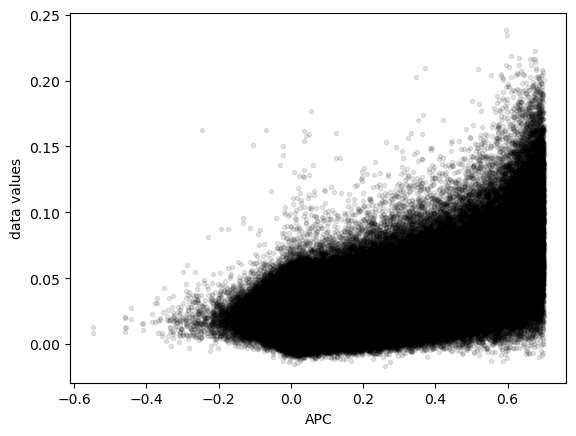

In [18]:
plt.figure()
plt.plot(apc2[lambda x: x.APC != -666].APC.values, apc2[lambda x: x.APC != -666].vals.values, 'k.', alpha=0.1)
plt.xlabel('APC')
plt.ylabel('data values')
plt.show()

In [27]:
apc2.head()

,sample_id,APC,nrepl,L1,L2,train,valid,vals
0,ABY001_A375_XH_X1_B15:A13,0.324414,8.0,1.649418,11.675443,True,False,0.095473
1,ABY001_A375_XH_X1_B15:A14,0.189060,10.0,1.265392,4.093121,True,False,0.080264
2,ABY001_A375_XH_X1_B15:A15,0.436836,9.0,2.257690,11.702172,True,False,0.089090
3,ABY001_A375_XH_X1_B15:A16,0.089820,8.0,0.961196,2.485945,True,False,0.056643
4,ABY001_A375_XH_X1_B15:A17,0.367309,8.0,1.855790,9.666554,True,False,0.046387


In [29]:
top80_idx = (apc2.vals >= apc2.vals.quantile(0.2)).values.nonzero()[0]

In [31]:
top80_train = l1000[train_idx, :][top80_idx, :]

: 

: 

In [ ]:
top80_train_dataset = AEDataset(top80_train)

/home/teddy/local/DVGS/manuscript_notebooks/../src/AEDataset.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [ ]:
model2 = AE(in_channels=978, latent_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, num_layers=1)
dvgs2 = DVGS(top80_train_dataset, valid_dataset=None, test_dataset=None, model=model)
dvgs2.pretrain_(crit=torch.nn.MSELoss(), num_workers=5, batch_size=512, lr=1e-3, epochs=3, use_cuda=True, verbose=True, report_metric=lambda x,y: r2_score(x,y, multioutput='uniform_average'))

using device: cuda

epoch: 0 | loss: 4.4388 | metric: 0.1074
epoch: 1 | loss: 4.4395 | metric: 0.1069
